# Assignment 5

## Part 1: Decision implementation on odinal data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Load car.data 
cols = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv("car.data", names=cols)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1728, 7)


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [3]:
# Explicit ordinal ordering for each attribute
ord_maps = [
    ["vhigh", "high", "med", "low"],   # buying
    ["vhigh", "high", "med", "low"],   # maint
    ["2", "3", "4", "5more"],          # doors
    ["2", "4", "more"],                # persons
    ["small", "med", "big"],           # lug_boot
    ["low", "med", "high"]             # safety
]

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

enc = OrdinalEncoder(categories=ord_maps)
X_encoded = enc.fit_transform(X)

print("Encoded feature sample:\n", X_encoded[:5])

Encoded feature sample:
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# Fully grown decision tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9913294797687862
              precision    recall  f1-score   support

         acc       0.97      0.99      0.98        77
        good       0.93      1.00      0.97        14
       unacc       1.00      1.00      1.00       242
       vgood       1.00      0.92      0.96        13

    accuracy                           0.99       346
   macro avg       0.98      0.98      0.98       346
weighted avg       0.99      0.99      0.99       346



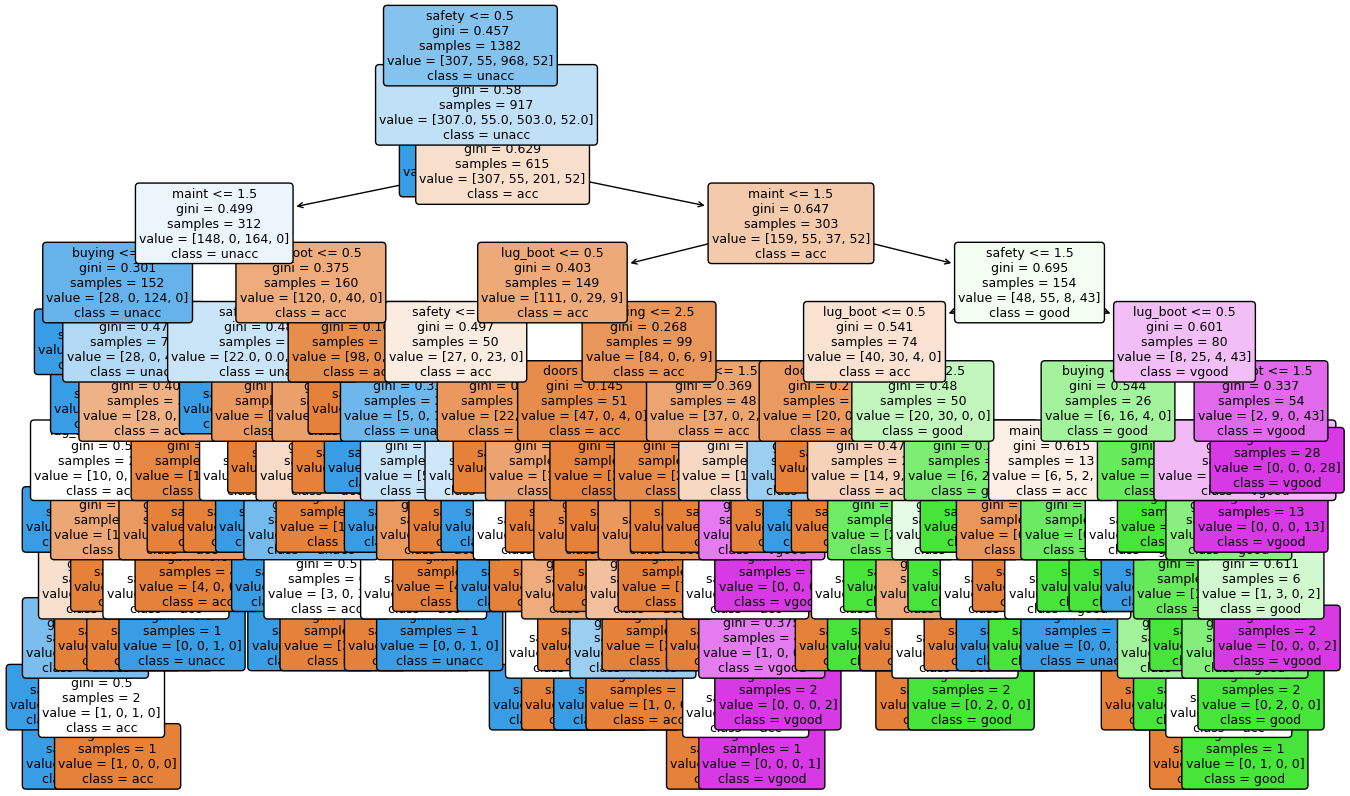

In [5]:
plt.figure(figsize=(16, 10))
plot_tree(
    clf,
    feature_names=cols[:-1],
    class_names=clf.classes_,
    filled=True,
    rounded=True,
    fontsize=9
)
plt.show()

In [6]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(clf, X_encoded, y, cv=5, scoring="accuracy")
print("Cross-validation accuracies:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))


Cross-validation accuracies: [0.77745665 0.71098266 0.72543353 0.90434783 0.85217391]
Mean CV accuracy: 0.7940789143000754


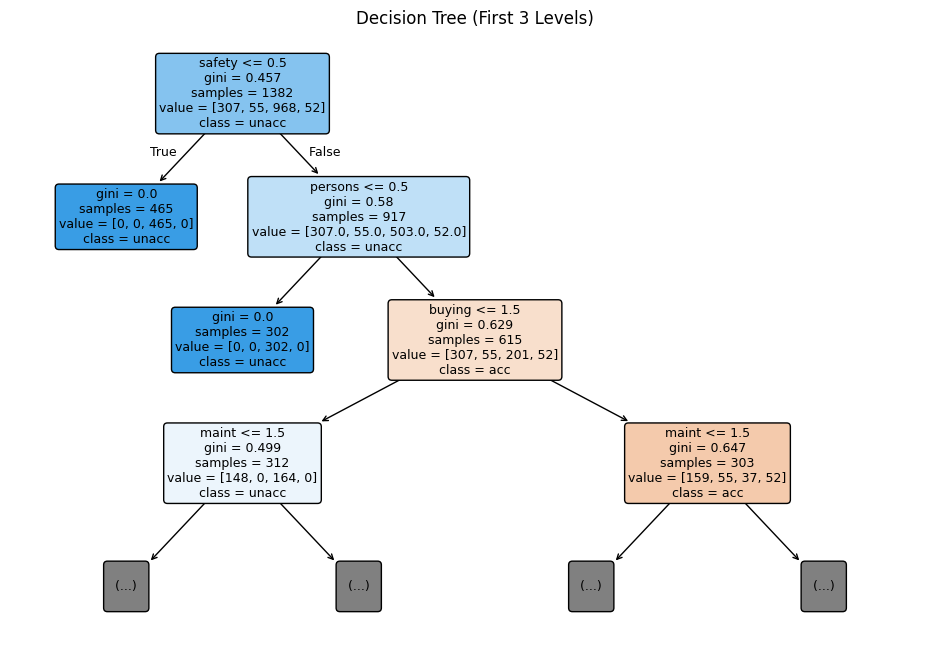

In [7]:
from sklearn import tree
import matplotlib.pyplot as plt

# Limit tree depth just for visualization (does not retrain model)
plt.figure(figsize=(12, 8))
tree.plot_tree(
    clf,
    feature_names=cols[:-1],
    class_names=clf.classes_,
    filled=True,
    rounded=True,
    fontsize=9,
    max_depth=3   # visualize only first 3 levels
)
plt.title("Decision Tree (First 3 Levels)")
plt.show()


## Part-2: Churn Dataset

In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

RANDOM_STATE = 42


In [9]:
path = "Telco-Customer-Churn_15081388-b1c7-4a07-a581-6b6a494e6346 (2).xlsx"
df = pd.read_excel(path)

print(df.shape)
df.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [10]:
# Try common target names
possible_targets = ["Churn", "churn", "CHURN"]
target_col = next((c for c in possible_targets if c in df.columns), None)
assert target_col is not None, "Couldn't find Churn column. Update target_col manually."

# Coerce typical numeric columns if present
for col in ["TotalCharges", "MonthlyCharges", "tenure"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows with missing target, and optionally impute features later
df = df.dropna(subset=[target_col]).copy()

# Trim whitespace in string columns
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# If 'customerID' exists and is an identifier, drop it
for id_col in ["customerID", "CustomerID", "customer_id"]:
    if id_col in df.columns:
        df = df.drop(columns=[id_col])

# Binary-ize target if strings like 'Yes'/'No'
if df[target_col].dtype == 'object':
    if set(df[target_col].unique()) <= {"Yes", "No"}:
        df[target_col] = (df[target_col] == "Yes").astype(int)

y = df[target_col]
X = df.drop(columns=[target_col])

print("Target positive rate:", y.mean())
print("X shape:", X.shape)


Target positive rate: 0.2653698707936959
X shape: (7043, 19)


In [11]:

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# We'll treat 'Contract' as ordinal if present
ord_cols = []
ord_categories = []

if "Contract" in cat_cols:
    ord_cols.append("Contract")
    ord_categories.append(["Month-to-month", "One year", "Two year"])

# (Optional) You can add more ordinal mappings if you're confident about order, e.g.:
# if "tech_support_level" in cat_cols: 
#     ord_cols.append("tech_support_level")
#     ord_categories.append(["None", "Basic", "Advanced"])

# Nominal columns are remaining categoricals minus ordinals
nom_cols = [c for c in cat_cols if c not in ord_cols]

print("Numeric:", num_cols)
print("Ordinal:", ord_cols)
print("Nominal:", nom_cols[:8], "... ({} nominal cols)".format(len(nom_cols)))


Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Ordinal: ['Contract']
Nominal: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup'] ... (14 nominal cols)


In [13]:
# Preprocessor (OrdinalEncoder for true ordinal, OneHot for nominal)
transformers = []

if ord_cols:
    transformers.append(("ord", OrdinalEncoder(categories=ord_categories, handle_unknown="use_encoded_value", unknown_value=-1), ord_cols))

if nom_cols:
    transformers.append(("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), nom_cols))

if num_cols:
    # passthrough numeric
    transformers.append(("num", "passthrough", num_cols))

preprocess = ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

transformers = []

if ord_cols:
    transformers.append(("ord", OrdinalEncoder(categories=ord_categories, handle_unknown="use_encoded_value", unknown_value=-1), ord_cols))

if nom_cols:
    transformers.append(("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), nom_cols))

if num_cols:
    # passthrough numeric
    transformers.append(("num", "passthrough", num_cols))

preprocess = ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)


In [15]:
full_tree = Pipeline([
    ("prep", preprocess),
    ("dt", DecisionTreeClassifier(
        random_state=RANDOM_STATE,  # fully grown: leave defaults (no max_depth, ccp_alpha=0)
    ))
])

full_tree.fit(X_train, y_train)
y_pred = full_tree.predict(X_test)

print("Fully-grown tree — Test report")
print(classification_report(y_test, y_pred, digits=4))


Fully-grown tree — Test report
              precision    recall  f1-score   support

           0     0.8179    0.8029    0.8103      1035
           1     0.4809    0.5053    0.4928       374

    accuracy                         0.7239      1409
   macro avg     0.6494    0.6541    0.6516      1409
weighted avg     0.7285    0.7239    0.7261      1409



In [16]:
# Pre-pruning via CV grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid = {
    "dt__max_depth": [None, 5, 8, 12, 16, 20],
    "dt__min_samples_split": [2, 10, 20],
    "dt__min_samples_leaf": [1, 5, 10],
    "dt__max_leaf_nodes": [None, 25, 50, 100],
}

prepruned = Pipeline([
    ("prep", preprocess),
    ("dt", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

gs = GridSearchCV(
    prepruned,
    param_grid=param_grid,
    scoring="f1" if len(np.unique(y))==2 else "accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
gs.fit(X_train, y_train)

print("Best pre-pruning params:", gs.best_params_)
print("CV best score:", gs.best_score_)
print("Test score:", gs.best_estimator_.score(X_test, y_test))

y_pred_pre = gs.best_estimator_.predict(X_test)
print("\nPre-pruned tree — Test report")
print(classification_report(y_test, y_pred_pre, digits=4))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best pre-pruning params: {'dt__max_depth': None, 'dt__max_leaf_nodes': 25, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 2}
CV best score: 0.5841452146414278
Test score: 0.7934705464868701

Pre-pruned tree — Test report
              precision    recall  f1-score   support

           0     0.8509    0.8715    0.8611      1035
           1     0.6189    0.5775    0.5975       374

    accuracy                         0.7935      1409
   macro avg     0.7349    0.7245    0.7293      1409
weighted avg     0.7894    0.7935    0.7911      1409



In [17]:
# Post-pruning: find α (cost-complexity pruning) with CV

# fiting an unpruned tree on TRAIN ONLY to get the α path
tmp_model = Pipeline([
    ("prep", preprocess),
    ("dt", DecisionTreeClassifier(random_state=RANDOM_STATE))
])
tmp_model.fit(X_train, y_train)

# Get the underlying trained tree to compute pruning path:
# We need the transformed X_train to call cost_complexity_pruning_path
Xtr_trans = tmp_model.named_steps["prep"].transform(X_train)
ytr = y_train.values if hasattr(y_train, "values") else y_train

from sklearn.tree import DecisionTreeClassifier
base = DecisionTreeClassifier(random_state=RANDOM_STATE)
base.fit(Xtr_trans, ytr)
path = base.cost_complexity_pruning_path(Xtr_trans, ytr)
ccp_alphas = np.unique(path.ccp_alphas)  # increasing sequence

# Cross-validating over alpha values (wrap inside a fresh pipeline)
alphas_to_try = np.linspace(ccp_alphas.min(), ccp_alphas.max(), num=min(50, len(ccp_alphas)))

post_scores = []
for a in alphas_to_try:
    model = Pipeline([
        ("prep", preprocess),
        ("dt", DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=a))
    ])
    cv_score = cross_val_score(model, X_train, y_train, scoring="f1" if len(np.unique(y))==2 else "accuracy",
                               cv=cv, n_jobs=-1).mean()
    post_scores.append(cv_score)

best_alpha = float(alphas_to_try[int(np.argmax(post_scores))])
best_alpha


0.014455730648082539

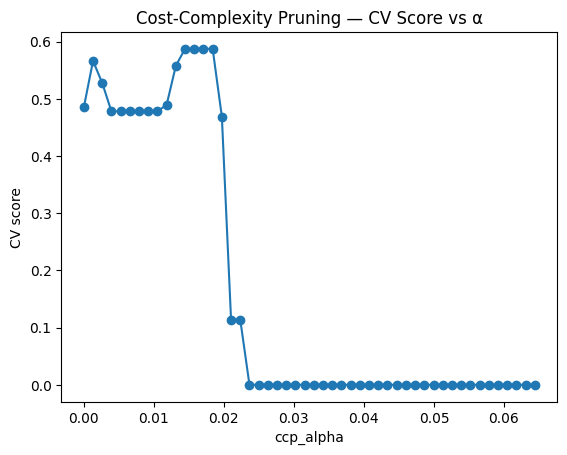

Selected α (ccp_alpha): 0.014455730648082539


In [18]:
# Plot CV score vs α (post-pruning curve)
plt.figure()
plt.plot(alphas_to_try, post_scores, marker="o")
plt.xlabel("ccp_alpha")
plt.ylabel("CV score")
plt.title("Cost-Complexity Pruning — CV Score vs α")
plt.show()

print("Selected α (ccp_alpha):", best_alpha)


In [19]:
# Train final post-pruned tree with best α and evaluate
postpruned = Pipeline([
    ("prep", preprocess),
    ("dt", DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=best_alpha))
])
postpruned.fit(X_train, y_train)

y_pred_post = postpruned.predict(X_test)
print("Post-pruned tree — Test report")
print(classification_report(y_test, y_pred_post, digits=4))


Post-pruned tree — Test report
              precision    recall  f1-score   support

           0     0.8462    0.8077    0.8265      1035
           1     0.5273    0.5936    0.5585       374

    accuracy                         0.7509      1409
   macro avg     0.6867    0.7007    0.6925      1409
weighted avg     0.7615    0.7509    0.7554      1409

